In [87]:
import simpy
import numpy as np

# Parámetros globales
N = 5  # Número de ONUs
#R = 500  # Tasa total de transmisión (Mbps)
T_cycle = 2  # Longitud del ciclo de polling (ms)
T_guard = 0.1  # Tiempo de resguardo (ms)
W = [0.3, 0.2, 0.1, 0.2, 0.2]  # SLA de cada ONU (debe sumar 1)

# Rango de valores para R (en Mbps)
#r_values = [1500]
r_values = range(1_200, 11_000, 1_000)  # De 1 Gbps a 10 Gbps en pasos de 1 Gbps
load_results = []
utilization_results = []

# Calcular B_min para cada ONU (constante para cada ONU)
B_min = [(T_cycle - 2 * N * T_guard) * W[i] * R / (8 * sum(W)) for i in range(N)]

# Clase ONU
class ONU:
    def __init__(self, id, avg_rate, b_min):
        self.id = id
        self.avg_rate = avg_rate  # Tasa promedio de generación (paquetes/ms)
        self.ef_request = 0  # Solicitudes para EF
        self.af_request = 0  # Solicitudes para AF
        self.be_request = 0  # Solicitudes para BE
        self.ef_grant = 0  # Asignación EF
        self.af_grant = 0  # Asignación AF
        self.be_grant = 0  # Asignación BE
        self.b_min = b_min  # B_min calculado previamente
        self.b_min_prime = b_min  # B_min' dinámico

    def generate_requests(self):
        """Generar solicitudes acumuladas para el ciclo."""
        self.ef_request = np.random.poisson(self.avg_rate * 0.2)  # 20% EF
        self.af_request = np.random.poisson(self.avg_rate * 0.5)  # 50% AF
        self.be_request = np.random.poisson(self.avg_rate * 0.3)  # 30% BE

# Clase OLT
class OLT:
    def __init__(self, env, num_onus, cycle_time, total_bandwidth, guard_time):
        self.env = env
        self.num_onus = num_onus
        self.cycle_time = cycle_time
        self.total_bandwidth = total_bandwidth
        self.guard_time = guard_time
        self.onus = []  # Lista de ONUs

    def allocate_bandwidth(self):
        """Asignar ancho de banda basado en prioridades."""
        total_allocated = 0  # Para rastrear el ancho de banda utilizado
    
        for onu in self.onus:
            # Generar solicitudes acumuladas del ciclo
            onu.generate_requests()
    
            # Paso 1: Calcular g_i^H (EF)
            onu.ef_grant = onu.ef_request  # g_i^H = H_i
            onu.b_min_prime = max(0, onu.b_min - onu.ef_grant)  # Actualizar B_min'
    
            # Comprobar si el sistema está en baja o alta carga
            if onu.af_request + onu.be_request <= onu.b_min_prime:
                # Baja carga
                onu.af_grant = onu.af_request  # G^M_i = M_i
                onu.be_grant = onu.be_request  # G^L_i = L_i
            else:
                # Alta carga
                # Paso 2: Calcular g_i^M (AF) y g_i^L (BE)
                onu.af_grant = min(onu.af_request, onu.b_min_prime)  # g_i^M
                onu.be_grant = max(0, onu.b_min_prime - onu.af_grant)  # g_i^L
    
                # Paso 3: Ajustar G_i^M y G_i^L según la fórmula
                onu.af_grant = min(onu.af_request + onu.b_min_prime - onu.ef_grant, onu.b_min_prime)  # G^M_i
                onu.be_grant = max(0, onu.b_min - onu.ef_grant - min(onu.af_request, onu.b_min_prime))  # G^L_i
    
            # Actualizar ancho de banda asignado
            total_allocated += onu.ef_grant + onu.af_grant + onu.be_grant
    
        # Redistribuir ancho de banda no utilizado entre BE
        remaining_bandwidth = self.total_bandwidth - total_allocated
        if remaining_bandwidth > 0:
            total_deficit = sum(
                (onu.af_request - onu.af_grant) + (onu.be_request - onu.be_grant) for onu in self.onus
            )
            if total_deficit > 0:
                for onu in self.onus:
                    # Calcular déficit de cada ONU
                    af_deficit = max(0, onu.af_request - onu.af_grant)
                    be_deficit = max(0, onu.be_request - onu.be_grant)
    
                    # Redistribuir proporcionalmente el ancho de banda restante
                    additional_allocation = (
                        ((af_deficit + be_deficit) / total_deficit) * remaining_bandwidth
                    )
    
                    # Asignar adicional primero a AF, luego a BE
                    if af_deficit > 0:
                        onu.af_grant += min(additional_allocation, af_deficit)
                        additional_allocation -= af_deficit
                    if additional_allocation > 0 and be_deficit > 0:
                        onu.be_grant += min(additional_allocation, be_deficit)

    
    def calculate_bandwidth_utilization(self):
        """Calcula la utilización del ancho de banda en el ciclo actual."""
        total_allocated = sum(
            onu.ef_grant + onu.af_grant + onu.be_grant for onu in self.onus
        )
        return (total_allocated / self.total_bandwidth) * 100
    
    def calculate_normalized_load(self):
        """Calcula la carga normalizada en el ciclo actual."""
        total_requests = sum(
            onu.ef_request + onu.af_request + onu.be_request for onu in self.onus
        )
        return total_requests / self.total_bandwidth
    
    def run(self):
        """Ejecutar ciclos de polling."""
        while True:
            # Recolectar solicitudes y asignar ancho de banda
            self.allocate_bandwidth()
            yield self.env.timeout(self.cycle_time)
    
    def print_results(self):
            # Calcular métricas
            normalized_load = self.calculate_normalized_load()
            utilization = self.calculate_bandwidth_utilization()
            # Imprimir resultados del ciclo
            print(f"Cycle {self.env.now}:")
            for onu in self.onus:
                print(f"ONU {onu.id}: EF={onu.ef_request}/{onu.ef_grant:.2f}, "
                      f"AF={onu.af_request}/{onu.af_grant:.2f}, "
                      f"BE={onu.be_request}/{onu.be_grant:.2f}, "
                      f"B_min'={onu.b_min_prime:.2f}")
            print(f"Cycle {self.env.now}: Load={normalized_load:.2f}, Utilization={utilization:.2f}%")
            

for r in r_values:
    # Configurar la simulación con el nuevo valor de R
    env = simpy.Environment()
    olt = OLT(env, N, T_cycle, r, T_guard)
    for i in range(N):
        onu = ONU(i, avg_rate=200, b_min=B_min[i])  # Tasa promedio de generación
        olt.onus.append(onu)
    
    # Ejecutar la simulación
    utilization_cycle = []
    load_cycle = []
    def collect_metrics():
        while True:
            olt.allocate_bandwidth()
            olt.print_results()
            load_cycle.append(olt.calculate_normalized_load())
            utilization_cycle.append(olt.calculate_bandwidth_utilization())
            yield env.timeout(T_cycle)

    env.process(collect_metrics())
    env.run(until=10)  # Simular 50 ms
    
    # Almacenar los promedios
    avg_load = sum(load_cycle) / len(load_cycle)
    avg_utilization = sum(utilization_cycle) / len(utilization_cycle)
    load_results.append(avg_load)
    utilization_results.append(avg_utilization)

Cycle 0:
ONU 0: EF=39/39.00, AF=93/93.00, BE=47/47.00, B_min'=0.00
ONU 1: EF=44/44.00, AF=93/93.00, BE=61/61.00, B_min'=0.00
ONU 2: EF=48/48.00, AF=110/110.00, BE=57/57.00, B_min'=0.00
ONU 3: EF=40/40.00, AF=85/85.00, BE=56/56.00, B_min'=0.00
ONU 4: EF=29/29.00, AF=93/93.00, BE=75/75.00, B_min'=0.00
Cycle 0: Load=0.81, Utilization=80.83%
Cycle 2:
ONU 0: EF=40/40.00, AF=92/92.00, BE=61/61.00, B_min'=0.00
ONU 1: EF=42/42.00, AF=101/101.00, BE=48/48.00, B_min'=0.00
ONU 2: EF=32/32.00, AF=110/110.00, BE=62/62.00, B_min'=0.00
ONU 3: EF=38/38.00, AF=96/96.00, BE=59/59.00, B_min'=0.00
ONU 4: EF=36/36.00, AF=90/90.00, BE=53/53.00, B_min'=0.00
Cycle 2: Load=0.80, Utilization=80.00%
Cycle 4:
ONU 0: EF=34/34.00, AF=93/93.00, BE=58/58.00, B_min'=0.00
ONU 1: EF=42/42.00, AF=97/97.00, BE=54/54.00, B_min'=0.00
ONU 2: EF=38/38.00, AF=105/105.00, BE=58/58.00, B_min'=0.00
ONU 3: EF=44/44.00, AF=95/95.00, BE=61/61.00, B_min'=0.00
ONU 4: EF=28/28.00, AF=96/96.00, BE=70/70.00, B_min'=0.00
Cycle 4: Load=0.8

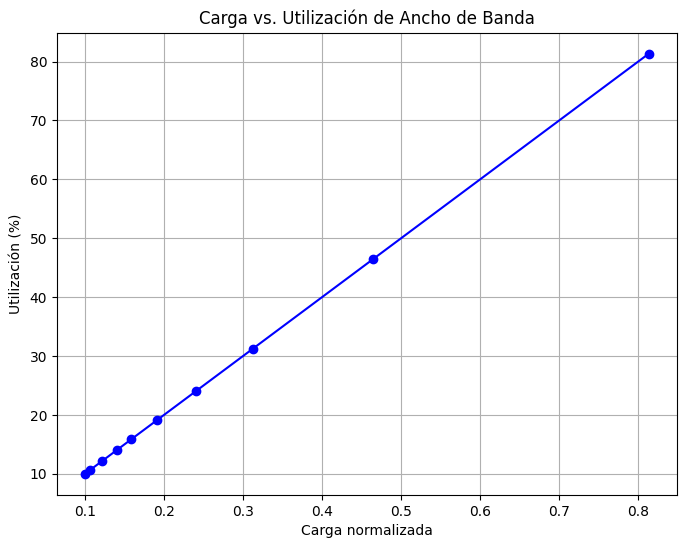

In [88]:
import matplotlib.pyplot as plt

# Graficar carga vs utilización
plt.figure(figsize=(8, 6))
plt.plot(load_results, utilization_results, marker='o', linestyle='-', color='b')
plt.title("Carga vs. Utilización de Ancho de Banda")
plt.xlabel("Carga normalizada")
plt.ylabel("Utilización (%)")
plt.grid(True)
plt.show()